In [22]:
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from multiprocessing import Pool
from pandas import concat
from pandas import DataFrame
from pandas import set_option
from os import listdir
from os.path import isfile
from time import sleep
from time import time
from random import choice
from pickle import dump
from pickle import load
from warnings import simplefilter
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np

set_option('display.max_colwidth',1000)
simplefilter(action='ignore', category=FutureWarning)

%run supported_models/sklRF
%run dataset
%run z3
%run viz_generator
%run experiment_scripts

In [23]:
#Data
train, test = download_openml_dataset_split( 'vote', .5 )
ds = test

#Random Forest
parameters = {'min_samples_leaf':[1],'n_estimators':[20]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=10)
clf = clf.fit(train.data, train.target)

#Logic Objects
RF = SciKitLearnRF(clf.best_estimator_,train)
engine = Z3(train,RF) #compute bounds over all data, but classifer has never seen test

#Find the samples where the RF is incorrect
predictions = clf.predict(test.data)
incorrect = []
for i in range(len(predictions)):
    if predictions[i]!=test.target[i]:
        print('Row%d:\t'%i,'target=%s'%test.targetMap[test.target[i]], 'output=%s'%test.targetMap[predictions[i]])
        incorrect.append(i)

Row4:	 target='democrat' output='republican'
Row34:	 target='republican' output='democrat'
Row38:	 target='democrat' output='republican'
Row126:	 target='republican' output='democrat'
Row128:	 target='republican' output='democrat'
Row138:	 target='republican' output='democrat'
Row162:	 target='republican' output='democrat'
Row181:	 target='republican' output='democrat'
Row184:	 target='republican' output='democrat'
Row185:	 target='republican' output='democrat'
Row191:	 target='democrat' output='republican'
Row197:	 target='democrat' output='republican'
Row199:	 target='democrat' output='republican'
Row206:	 target='democrat' output='republican'


# Why does the model disagree with the ground truth label?

In [ ]:
MUCs=[]
for idx in incorrect:
    print(idx)
    MUCs.append(get_explanation([idx,predictions[idx],ds,engine]))

In [ ]:
# Create a table of explanations for writeup
explanations=[]
for MUC in MUCs:
    explanations.append(rationalize_behavior_by_category(MUC,test,predictions))

rationalization = {'Test ID':[i for i in incorrect],
                   'Ground Truth':[test.targetMap[test.target[i]].upper()[1:4] for i in incorrect],
                   'Model Output':[test.targetMap[clf.predict(test.data)[i]].upper()[1:4] for i in incorrect],
                   'Attribute Values':[explanations[i]['input'] if type(explanations[i])==dict else '' for i in range(len(incorrect)) ],
                   'Threshold Values':[explanations[i]['threshold'] if type(explanations[i])==dict else '' for i in range(len(incorrect)) ],
                   'Leaf Assignments':[explanations[i]['leaf'] if type(explanations[i])==dict else '' for i in range(len(incorrect)) ]
                  }
explanation_df = DataFrame(data=rationalization)
# print(explanation_df.to_latex(index=False))

# What can we do to change the model?

In [ ]:
num_processors = 30
p=Pool(processes = num_processors)
output = p.map(get_interventions ,[(i,ds,clf,engine,train) for i in incorrect[:10]])
p.close()

In [ ]:
#Look at why_not_row191_prediction.model
rowID=64
#199 253 183 6 244 294 283
with open('output/intervention_row%d.pkl'%(rowID),'rb') as f:
    output=load(f)
print(output)
dot = Digraph(comment='SAT Model',graph_attr={'splines':'spline'})#{'splines':'ortho'})
models = viz_rf(engine.assert_branches(),engine.assert_rules(),engine.assert_leaves(),output[1],output[2])#interventions,changes)
dot.subgraph(models)
dot#.render('intervention_tree_55', view=True)

# When should we not trust model output?

In [24]:
cD=get_distrust_regions(engine,ds)

confusing = DataFrame(columns=train.data.columns)
for elem in cD:
    confusing = confusing.append([elem])


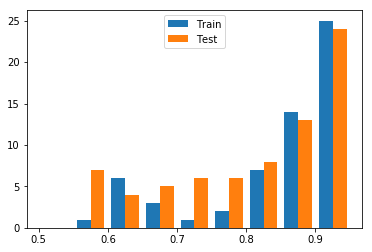

In [29]:
# *** Show the random forest's confidence (Low for confusing samples)
trainprobs = clf.best_estimator_.predict_proba(train.data)
trainprobs = [max(trainprobs[i]) for i in range(len(trainprobs))]

testprobs = clf.best_estimator_.predict_proba(test.data)
testprobs = [max(testprobs[i]) for i in range(len(testprobs))]

confusingprobs = clf.best_estimator_.predict_proba(confusing)
confusingprobs = [max(confusingprobs[i]) for i in range(len(confusingprobs))]

plt.figure()
#plt.hist(confusingprobs,bins=np.arange(.5,1,.05),label=('Confusing0'))
#plt.hist(testprobs,bins=np.arange(.5,1,.05),label=('Test0'))
#plt.hist(trainprobs,bins=np.arange(.5,1,.05),label=('Train0'))
plt.hist([trainprobs,testprobs],bins=np.arange(.5,1,.05),label=(['Train','Test']))
plt.legend(loc='upper center')

# *** Show the individual trees confidence (High for confusing samples) ***
# for modelID in range(10):
#     trainprobs = clf.best_estimator_.estimators_[modelID].predict_proba(train.data)
#     trainprobs = [max(trainprobs[i]) for i in range(len(trainprobs))]

#     testprobs = clf.best_estimator_.estimators_[modelID].predict_proba(test.data)
#     testprobs = [max(testprobs[i]) for i in range(len(testprobs))]

#     confusingprobs = clf.best_estimator_.estimators_[modelID].predict_proba(confusing)
#     confusingprobs = [max(confusingprobs[i]) for i in range(len(confusingprobs))]

#     plt.figure()
#     plt.hist(confusingprobs,label=('Confusing0'))
#     plt.hist(testprobs,label=('Test0'))
#     plt.hist(trainprobs,label=('Train0'))
#     plt.legend(loc='upper center')

In [34]:
len(testprobs)

217

In [ ]:
xtrain = train.data
ytrain = [0 for elem in train.target]
xtest = test.data
ytest = [1 for elem in test.target]
xconfusing = confusing[:220]
yconfusing = [2 for elem in range(220)]

xall = concat([xtrain,xtest,xconfusing])
yall = ytrain+ytest+yconfusing

X=xall
y=yall
n_samples, n_features = X.shape
n_neighbors = 100

# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig=plt.figure(figsize=(12, 8),frameon=False)
    #ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i,0],X[i,1],marker=['+','_','o'][y[i]],color='black',facecolors=['black','black','none'][y[i]])#['black','black','white'][y[i]])

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title,fontdict={'fontsize':14,})
    fig.savefig('tsne_3.pdf', format='pdf',bbox_inches='tight', pad_inches=0)

print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca',random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)


In [ ]:
get_cdist(xall,yall)